# Projeto Inteligência Artifical (Afonso Fernandes - 2221437, Luís Oliveira - 2221441)

- Conjunto de validação train4

## Modelos:

### S

- Modelo de raíz 

- Otimizador: 

- Com e sem Data Augmentation

### T

- Modelo transfer learning

- Otimizador: 

- Com e sem Data Augmentation

## Dados Base:

In [ ]:
from keras.utils import image_dataset_from_directory
import tensorflow as tf
train_dir_1 = 'trainning/train1'
train_dir_2 = 'trainning/train2'
train_dir_3 = 'trainning/train3'
validation_dir = 'train4' # Validation
train_dir_5 = 'trainning/train5'
test_dir = 'test'

trainning = [train_dir_1, train_dir_2,train_dir_3,train_dir_5]

train_dir = train_dir_2
IMG_SIZE = 32 # 32x32

# image_dataset_from_directory with labels="inferred" for 
# getting the images in the subdirectories and translating the subdirectory as a class 
# of type categorical
#train_dataset = image_dataset_from_directory(train_dir,image_size=(IMG_SIZE, IMG_SIZE),batch_size=32, labels="inferred", label_mode="categorical")
test_dataset = image_dataset_from_directory(test_dir,image_size=(IMG_SIZE, IMG_SIZE), labels="inferred",label_mode="categorical")
validation_dataset = image_dataset_from_directory(validation_dir,image_size=(IMG_SIZE, IMG_SIZE), labels="inferred",label_mode="categorical")

train_dataset = tf.data.Dataset

for i in trainning:
    if i == trainning[0]:
        train_dataset = image_dataset_from_directory(i, image_size=(IMG_SIZE, IMG_SIZE), labels="inferred", label_mode="categorical")
        continue
    train_dataset = train_dataset.concatenate( image_dataset_from_directory(i, image_size=(IMG_SIZE, IMG_SIZE), labels="inferred", label_mode="categorical"))




In [ ]:
import matplotlib.pyplot as plt

def graph(history):
    # Use the correct key names from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [ ]:
import matplotlib.pyplot as plt
for data_batch, labels_batch in train_dataset:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break
for data_batch, _ in train_dataset.take(1):
  for i in range(3):
    plt.imshow(data_batch[i].numpy().astype("uint8"))
    plt.show()

## Modelo S sem Data augmentation:

- Primeiro modelo de teste:

In [ ]:
from tensorflow import keras
from keras import layers
from keras import models
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=64, kernel_size=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.6)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['val_loss'])

In [ ]:
import os
import tensorflow as tf

model_path = "models_S/model_best.h5"
model =  tf.keras.models.load_model(model_path)


In [ ]:
model.summary()

### Optimização da procura de hyperparâmetros através do optuna 

In [ ]:
import optuna
import keras
from keras import layers



def create_model(trial):
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 3)
    #making the model
    reg = keras.regularizers.l2(0.005)
    dropConv = 0.2
    dropFinal = 0.5
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)
    for i in range(n_conv_layers):
        n_filters = trial.suggest_int('n_filters1_{}'.format(i), 32, 128, step=32)
        n_filters2 = trial.suggest_int('n_filters2_{}'.format(i), 32, 128, step=32)
        n_ksize = trial.suggest_int('n_ksize1_{}'.format(i), 2, 3)
        n_ksize1 = trial.suggest_int('n_ksize2_{}'.format(i), 2, 3)
        x = layers.Conv2D(filters=n_filters, kernel_size=n_ksize,padding="same", activation="relu",kernel_regularizer=reg)(x)
        x = layers.BatchNormalization(axis=-1)(x)
        x = layers.Conv2D(filters=n_filters2, kernel_size=n_ksize1,padding="same", activation="relu",kernel_regularizer=reg)(x)
        x = layers.BatchNormalization(axis=-1)(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Dropout(dropConv)(x)

        
    #The flatten and classification process    
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu", kernel_regularizer=reg)(x) #trial.suggest_int('dense_units', 512, 1024, step=512)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropFinal)(x)

    outputs = layers.Dense(10, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=trial.suggest_float('learning_rate_IN', 1e-3, 1e-2, log=True),
    decay_steps=10000,
    decay_rate=0.6)

    # Suggest optimizer
    optimizer_options = ['Adam', 'RMSprop']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    if optimizer_selected == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def objective(trial):
    model = create_model(trial)
    
    callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='models_S/model_best.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=0
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=4,
        verbose=0,
        mode='min',
        restore_best_weights=True,
    ),keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=0
    )]
    batch_size = trial.suggest_int('batch_size', 32, 128, step=32)

    
    history = model.fit(train_dataset,
                        batch_size=batch_size,
                        epochs=30,  
                        validation_data=validation_dataset,
                        callbacks=[callbacks],
                        verbose=0)  # não verboso
    graph(history)
    val_loss = history.history['val_loss'][-1]
    return val_loss

### Utilização do Optuna:
- Criação do Modelo com os campos dos hyperparâmetros com sugestões de valores para serem testados

- Definição do objetivo de maximizar a accuracy e callback para guardar sempre o melhor modelo definido pela accuracy 

[I 2024-06-19 17:12:17,850] A new study created in memory with name: no-name-c2f53027-0f57-40d9-a0d9-0a731b6b2db8

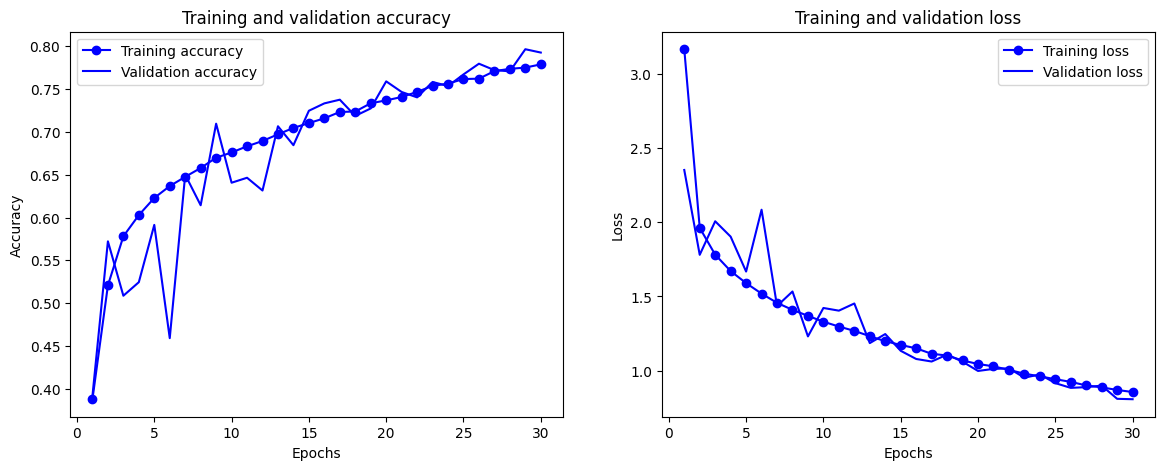

[I 2024-06-19 18:05:48,769] 

Trial 1 finished with value: 0.8066616654396057 and parameters: 

{'n_conv_layers': 3, 

'n_filters1_0': 128, 

'n_filters2_0': 96, 

'n_ksize1_0': 3, 

'n_ksize2_0': 2, 

'n_filters1_1': 32, 

'n_filters2_1': 32, 

'n_ksize1_1': 3, 

'n_ksize2_1': 2, 

'n_filters1_2': 96, 

'n_filters2_2': 32,

 'n_ksize1_2': 2, 
 
 'n_ksize2_2': 2, 
 
 'learning_rate_IN': 0.0020018655778243685, 
 
 'optimizer': 'RMSprop', 
 
 'batch_size': 128}. 
 
 Best is trial 1 with value: 0.8066616654396057.


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=6)  # Ajustar número de trials para um estudo mais completo

print(f"Best trial: {study.best_trial.params}")


### Os melhores hyperparâmetros encontrados no estudo:

Best trial: 
{
    
    'n_conv_layers': 1, 
    
    'n_filters_0': 96, 
    
    'n_ksize_0': 2, 
    
    'dense_units': 256, 
    
    'learning_rate_IN': 0.00018260436634761802, 
    
    'optimizer': 'Adam'
    
}




- Depois de um estudo retirar os melhores hyperparâmetros e treinar

In [ ]:
study.best_trial.params
# model = create_model(study.best_trial)
# val_loss, val_acc = model.evaluate(test_dataset)
# print('val_acc:', val_acc,'\nval_loss:', val_loss)

- Com o modelo já carregado do ficheiro, continuar o treino

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='models_S/model_bestNew2.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True,
)]
    
    
history = model.fit(
    train_dataset,
    epochs=100,  
    batch_size=8,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)  # # sim/não verboso

- Avaliar Modelo:

In [ ]:
val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc,'\nval_loss:', val_loss)

- Guardar o modelo depois de ter sido treinado:

In [ ]:
keras.models.save_model(model,"models_S\model_best_firstIteration.h5")

## Modelo S com Data augmentation:

- Parecido com o feito anteriormente mas com Data augmentation:

### Optimização da procura de hyperparâmetros através do optuna com Data Augmentation

In [ ]:
import optuna
import keras
from keras import layers


def create_model(trial):
    n_conv_layers = trial.suggest_int('n_conv_layers', 2, 3)
    # Definição da augmentação da informação
    reg = keras.regularizers.l2(0.005)
    dropConv = 0.2
    dropFinal = 0.5
    data_augmentation = keras.Sequential(
        [layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),])
    #
    # Criação do dito Modelo
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    # Data augmentation
    x = data_augmentation(inputs)
    #
    x = layers.Rescaling(1./255)(inputs)
    for i in range(n_conv_layers):
        n_filters = trial.suggest_int('n_filters1_{}'.format(i), 32, 128, step=32)
        #n_filters2 = trial.suggest_int('n_filters2_{}'.format(i), 32, 128, step=32)
        n_filters2 = n_filters 
        n_ksize = trial.suggest_int('n_ksize1_{}'.format(i), 2, 3)
        #n_ksize1 = trial.suggest_int('n_ksize2_{}'.format(i), 2, 3)
        n_ksize1 = n_ksize
        x = layers.Conv2D(filters=n_filters, kernel_size=n_ksize,padding="same", activation="relu",kernel_regularizer=reg)(x)
        x = layers.BatchNormalization(axis=-1)(x)
        x = layers.Conv2D(filters=n_filters2, kernel_size=n_ksize1,padding="same", activation="relu",kernel_regularizer=reg)(x)
        x = layers.BatchNormalization(axis=-1)(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Dropout(dropConv)(x)

        
    #The flatten and classification process    
    x = layers.Flatten()(x)
    x = layers.Dense(trial.suggest_int('dense_units', 256, 512, step=256), activation="relu", kernel_regularizer=reg)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropFinal)(x)

    outputs = layers.Dense(10, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=trial.suggest_float('learning_rate_IN', 1e-3, 1e-2, log=True),
    decay_steps=10000,
    decay_rate=0.6)

    # Suggest optimizer
    optimizer_options = ['Adam', 'RMSprop']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    if optimizer_selected == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def objective(trial):
    model = create_model(trial)
    
    callbacks = [keras.callbacks.ModelCheckpoint(
        filepath='models_S/model_best_DA_SecondOption.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=0
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=4,
        verbose=1,
        mode='min',
        restore_best_weights=True,
    ),keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=0
    )]
    batch_size = trial.suggest_int('batch_size', 32, 128, step=32)

    
    history = model.fit(train_dataset,
                        batch_size=batch_size,
                        epochs=50,  
                        validation_data=validation_dataset,
                        callbacks=callbacks,
                        verbose=0)  # não verboso
    graph(history)
    val_loss = history.history['val_loss'][-1]
    return val_loss

### Utilização do Optuna:
- Criação do Modelo com os campos dos hyperparâmetros com sugestões de valores para serem testados

- Definição do objetivo de maximizar a accuracy e callback para guardar sempre o melhor modelo definido pela accuracy 

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)   # Ajustar número de trials para um estudo mais completo

print(f"Best trial: {study.best_trial.params}")


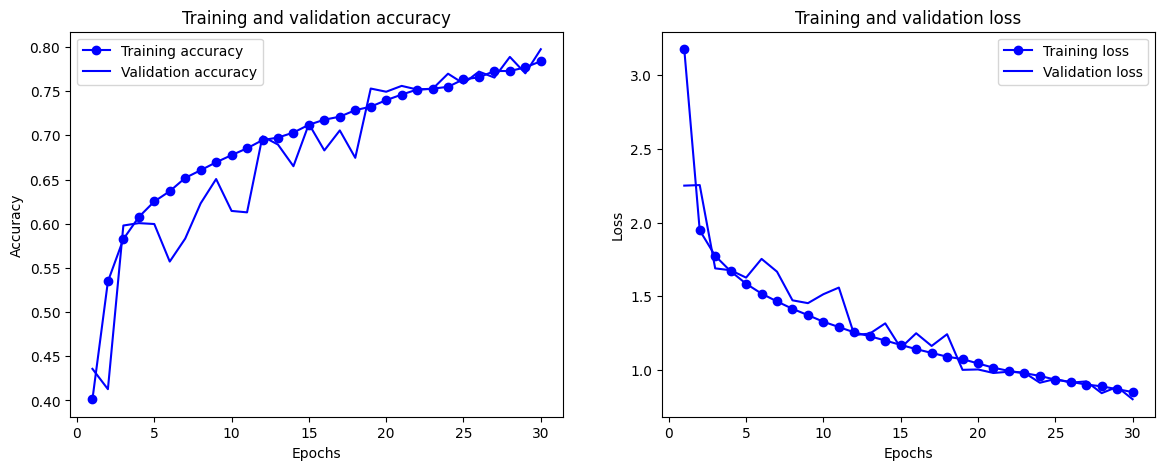

Utilização dos parâmetros encontrados no Modelo S sem Data Augmentation

In [ ]:
graph(history)

In [ ]:
best_params = study.best_trial
# Treinar o modelo com os melhores hyperparâmetros
best_model = create_model(best_params)
history = best_model.fit(train_dataset,epochs=30,batch_size=128,validation_data=validation_dataset)

- Depois de um estudo retirar os melhores hyperparâmetros e treinar

In [ ]:
import keras
# Load do novo melhor modelo
model = keras.models.load_model("models_S\model_best_DA.h5")

In [ ]:
model.summary()

In [ ]:
callbacks = [ keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=4,
        verbose=0,
        mode='min',
        restore_best_weights=True,
    ),keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=0
    )]
    
    
history = best_model.fit(
    train_dataset,
    epochs=100, batch_size=128, 
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

- Avaliar Modelo:

In [ ]:
val_loss, val_acc = best_model.evaluate(validation_dataset)
print('val_acc:', val_acc,'\nval_loss:', val_loss)

- Guardar o modelo depois de ter sido treinado:

In [ ]:
keras.models.save_model(best_model,"models_S\model_best_DA.h5")